# 0. Introduction and Importing

First, we import the most fundamental packages/modules of PyTorch.

In [33]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import glob
import numpy as np
from torch.utils.data import random_split
import torch.optim as optim
import torch
import torch.nn as nn
from torchvision.models import resnet18

Import some generic helper packages

In [34]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time
import cv2


# Dataset analysis

In [37]:
data_path="../dataset/sync/"

# Get all image file paths in the dataset
rgb_image_paths = []
depth_image_paths = []

for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith('.jpg'):
            rgb_image_paths.append(os.path.join(root, file))
        if file.endswith('.png'):
            depth_image_paths.append(os.path.join(root, file))

print(f'Total RGB images: {len(rgb_image_paths)}')
print(f'Total Depth images: {len(depth_image_paths)}')


Total RGB images: 36396
Total Depth images: 36396


In [38]:
# Choose a sample image from the dataset
sample_rgb_path = os.path.join(data_path, 'basement_0001a', 'rgb_00000.jpg')
sample_depth_path = os.path.join(data_path, 'basement_0001a', 'sync_depth_00000.png')

# Load the sample RGB image and get its resolution and format
rgb_image = cv2.imread(sample_rgb_path)
rgb_height, rgb_width, rgb_channels = rgb_image.shape
rgb_format = sample_rgb_path.split('.')[-1]

# Load the sample depth image and get its resolution and format
depth_image = cv2.imread(sample_depth_path, cv2.IMREAD_ANYDEPTH)
depth_height, depth_width = depth_image.shape
depth_format = sample_depth_path.split('.')[-1]


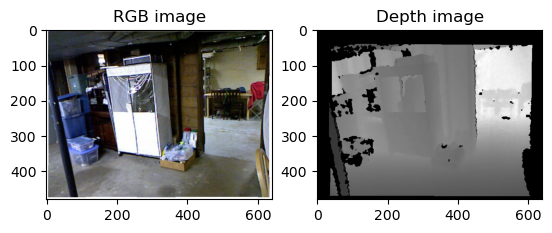

In [39]:
# Load the sample RGB image and get its resolution and format
rgb_image = cv2.imread(sample_rgb_path)
rgb_height, rgb_width, rgb_channels = rgb_image.shape
rgb_format = sample_rgb_path.split('.')[-1]

# Load the sample depth image and get its resolution and format
depth_image = cv2.imread(sample_depth_path, cv2.IMREAD_ANYDEPTH)
depth_height, depth_width = depth_image.shape
depth_format = sample_depth_path.split('.')[-1]

# Plot the RGB and depth images
fig, axs = plt.subplots(1, 2)
axs[0].imshow(cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB))
axs[0].set_title('RGB image')
axs[1].imshow(depth_image, cmap='gray')
axs[1].set_title('Depth image')
plt.show()

In [40]:
data_path = "../dataset/sync/"
rgb_filenames = []
depth_filenames = []
for folder in sorted(glob.glob(os.path.join(data_path, "*"))):
    rgb_filenames.extend(sorted(glob.glob(os.path.join(folder, "rgb_*.jpg"))))
    depth_filenames.extend(sorted(glob.glob(os.path.join(folder, "sync_depth_*.png"))))

In [41]:
min_rgb = torch.zeros(3)
max_rgb = torch.zeros(3)
mean_rgb = torch.zeros(3)
std_rgb = torch.zeros(3)
mean_depth = torch.zeros(1)
std_depth = torch.zeros(1)
min_depth = torch.zeros(1)
max_depth = torch.zeros(1)

for i in range(len(rgb_filenames)):
    rgb, depth = rgb_filenames[i], depth_filenames[i]
        
    rgb = Image.open(rgb)
    depth = Image.open(depth)

    # Convert images to numpy arrays and add extra dimension
    rgb_arr = np.array(rgb).transpose((2, 0, 1))[np.newaxis, :, :, :]
    depth_arr = np.array(depth)[np.newaxis, np.newaxis, :, :]

    # Compute mean and std for RGB images
    min_rgb += torch.min(torch.FloatTensor(rgb_arr).float())
    max_rgb += torch.max(torch.FloatTensor(rgb_arr).float())
    mean_rgb += torch.mean(torch.FloatTensor(rgb_arr).float(), dim=(0, 2, 3))
    std_rgb += torch.std(torch.FloatTensor(rgb_arr).float(), dim=(0, 2, 3))

    # Compute mean, std, min, and max for depth images
    mean_depth += torch.mean(torch.FloatTensor(depth_arr).float())
    std_depth += torch.std(torch.FloatTensor(depth_arr).float())
    min_depth += torch.min(torch.FloatTensor(depth_arr).float())
    max_depth += torch.max(torch.FloatTensor(depth_arr).float())

min_rgb /= len(rgb_filenames)
max_rgb /= len(rgb_filenames)
mean_rgb /= len(rgb_filenames)
std_rgb /= len(rgb_filenames)
mean_depth /= len(depth_filenames)
std_depth /= len(depth_filenames)
min_depth /= len(depth_filenames)
max_depth /= len(depth_filenames)


In [42]:
# min_depth = torch.zeros(1)
# max_depth = torch.zeros(1)
# mean_depth = torch.zeros(1)
# std_depth = torch.zeros(1)

# for i in range(len(rgb_filenames)):
#     rgb, depth = rgb_filenames[i], depth_filenames[i]
        
#     rgb = Image.open(rgb)
#     depth = Image.open(depth)

#     # Convert images to numpy arrays and add extra dimension
#     rgb_arr = np.array(rgb).transpose((2, 0, 1))[np.newaxis, :, :, :]
#     depth_arr = np.array(depth)[np.newaxis, np.newaxis, :, :]

#     # Compute mean and std for RGB images
#     min_rgb += torch.min(torch.FloatTensor(rgb_arr).float())
#     max_rgb += torch.max(torch.FloatTensor(rgb_arr).float())
#     mean_rgb += torch.mean(torch.FloatTensor(rgb_arr).float(), dim=(0, 2, 3))
#     std_rgb += torch.std(torch.FloatTensor(rgb_arr).float(), dim=(0, 2, 3))

#     # Compute mean, std, min, and max for depth images
#     mean_depth += torch.mean(torch.FloatTensor(depth_arr).float())
#     std_depth += torch.std(torch.FloatTensor(depth_arr).float())
#     min_depth += torch.min(torch.FloatTensor(depth_arr).float())
#     max_depth += torch.max(torch.FloatTensor(depth_arr).float())

# min_rgb /= len(rgb_filenames)
# max_rgb /= len(rgb_filenames)
# mean_rgb /= len(rgb_filenames)
# std_rgb /= len(rgb_filenames)
# mean_depth /= len(depth_filenames)
# std_depth /= len(depth_filenames)
# min_depth /= len(depth_filenames)
# max_depth /= len(depth_filenames)


In [43]:
# mean_rgb = torch.zeros(3)
# std_rgb = torch.zeros(3)
# mean_depth = torch.zeros(1)
# std_depth = torch.zeros(1)

# for i in range(len(rgb_filenames)):
#     rgb, depth = rgb_filenames[i], depth_filenames[i]
        
#     rgb = Image.open(rgb)
#     depth = Image.open(depth)

#     # Convert images to numpy arrays and add extra dimension
#     rgb_arr = np.array(rgb).transpose((2, 0, 1))[np.newaxis, :, :, :]
#     depth_arr = np.array(depth)[np.newaxis, np.newaxis, :, :]

#     # Compute mean and std for RGB images
#     mean_rgb += torch.mean(torch.FloatTensor(rgb_arr).float(), dim=(0, 2, 3))
#     std_rgb += torch.std(torch.FloatTensor(rgb_arr).float(), dim=(0, 2, 3))

#     # Compute mean and std for depth images
#     mean_depth += torch.mean(torch.FloatTensor(depth_arr).float())
#     std_depth += torch.std(torch.FloatTensor(depth_arr).float())

# mean_rgb /= len(rgb_filenames)
# std_rgb /= len(rgb_filenames)
# mean_depth /= len(depth_filenames)
# std_depth /= len(depth_filenames)


In [44]:
print(f'RGB min: {min_rgb}')
print(f'RGB max: {max_rgb}')
print(f'RGB mean: {mean_rgb / 255}')
print(f'RGB std: {std_rgb / 255}')
print(f'Depth min: {min_depth}')
print(f'Depth max: {max_depth}')
print(f'Depth mean: {mean_depth / max_depth}')
print(f'Depth std: {std_depth / max_depth}')

RGB min: tensor([0.0077, 0.0077, 0.0077])
RGB max: tensor([255., 255., 255.])
RGB mean: tensor([0.4879, 0.4179, 0.4011])
RGB std: tensor([0.2648, 0.2732, 0.2828])
Depth min: tensor([0.])
Depth max: tensor([5780.2031])
Depth mean: tensor([0.3281])
Depth std: tensor([0.2751])
